In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import torch


import random
%matplotlib inline

In [2]:
# Define our bandpass filter

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = scipy.signal.sosfilt(sos, data)
        return y

In [3]:
# Reload the EEG Data we captured on the last Jupyter Notebook
dataset_unfiltered = []
for i in range(1,5):
    data = np.load(f'5m_{i}.npy')
    dataset_unfiltered.append(data)
dataset_unfiltered = np.vstack(dataset_unfiltered)

mean, std = np.mean(dataset_unfiltered), np.std(dataset_unfiltered)

# remove noisy 'bits' that was causing weird results. i.e. sometimes samples we exactly 65,536 to high or low.
dataset_unfiltered = np.where(dataset_unfiltered > mean + std*10, dataset_unfiltered - 2**16, dataset_unfiltered)
dataset_unfiltered = np.where(dataset_unfiltered < mean - std*10, dataset_unfiltered + 2**16, dataset_unfiltered)
dataset_unfiltered = dataset_unfiltered - mean
dataset_unfiltered = dataset_unfiltered / std

# make sure we are the right data type
dataset_unfiltered = dataset_unfiltered.astype(np.float32)


In [4]:
# Use the bandpass filter on the samples
# We'll overlap each sample by half, to get more samples. 
dataset_filtered = []
for row in range(dataset_unfiltered.shape[0]):
    for start in range(0, dataset_unfiltered.shape[1] - 1024, 512):
        sample = butter_bandpass_filter(dataset_unfiltered[row, start:start+1024], lowcut=5, highcut=35, fs=4096, order=6)
        dataset_filtered.append(sample)
dataset_filtered = np.vstack(dataset_filtered).astype(np.float32)        

In [5]:
# Out Autoencoder Parameters
CUDA = True
SEED = 1
BATCH_SIZE = 64
LOG_INTERVAL = 10
EPOCHS = 50
EPOCHS_INTERVAL = 5
AE_PARAMS = 20
TRAINING_SET_SIZE = 0.8

CUDA_LAUNCH_BLOCKING=1 

In [6]:
# Our custom Dataset class
class EEGDataset(Dataset):
    """EEG dataset."""

    def __init__(self, data_np):
        self.data = data_np
        
    def __len__(self):      
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx, :]

In [7]:
# Instantiate the dataset, and create training and test data sets
full_dataset = EEGDataset(dataset_filtered)

train_size = int(TRAINING_SET_SIZE * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# the PyTorch DataLoader class handles randomization and feeding the Autencoder with data
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

In [8]:
# Finally our Autoencoder!
class AE(nn.Module):
    def __init__(self, ae_width):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, ae_width)
        self.fc4 = nn.Linear(ae_width, 64)
        self.fc5 = nn.Linear(64, 256)
        self.fc6 = nn.Linear(256, 1024)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def decode(self, x):
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

    def forward(self, x):
        x = self.encode(x.view(-1, 1024))
        return self.decode(x)

In [9]:
# Instantiate the Auroencoder
model = AE(AE_PARAMS)

# Push it onto the GPU
model.cuda()

print(model)

AE(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=1024, bias=True)
)


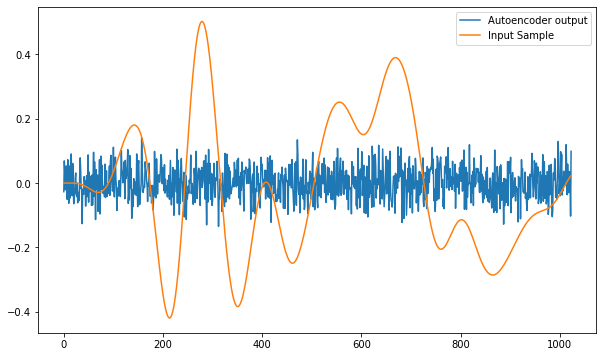

In [10]:
# Before Training, this is how well our Autoencoder can reconstruct the EEG data
with torch.no_grad():
    plt.figure(figsize=(10,6))
    x= model.encode(torch.from_numpy(full_dataset[1]).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    plt.plot(out, label='Autoencoder output') 
    plt.plot(full_dataset[1], label='Input Sample')
    plt.legend()

In [11]:
# Define how we optimizem, train, and test the Autoencoder

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = F.mse_loss(recon_batch, data.view(-1, 1024), reduction='sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            recon_batch = model(data)
            test_loss += F.mse_loss(recon_batch, data.view(-1, 1024), reduction='sum')

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


Train Epoch: 1 [0/7673 (0%)]	Loss: 154.429688
Train Epoch: 1 [640/7673 (8%)]	Loss: 168.946121
Train Epoch: 1 [1280/7673 (17%)]	Loss: 172.730911
Train Epoch: 1 [1920/7673 (25%)]	Loss: 139.177765
Train Epoch: 1 [2560/7673 (33%)]	Loss: 139.931442
Train Epoch: 1 [3200/7673 (42%)]	Loss: 143.990692
Train Epoch: 1 [3840/7673 (50%)]	Loss: 142.401138
Train Epoch: 1 [4480/7673 (58%)]	Loss: 136.026703
Train Epoch: 1 [5120/7673 (67%)]	Loss: 163.292770
Train Epoch: 1 [5760/7673 (75%)]	Loss: 111.019295
Train Epoch: 1 [6400/7673 (83%)]	Loss: 104.697037
Train Epoch: 1 [7040/7673 (92%)]	Loss: 109.780167
====> Epoch: 1 Average loss: 142.4833
====> Test set loss: 105.2637
Train Epoch: 2 [0/7673 (0%)]	Loss: 95.928734
Train Epoch: 2 [640/7673 (8%)]	Loss: 101.550255
Train Epoch: 2 [1280/7673 (17%)]	Loss: 107.033936
Train Epoch: 2 [1920/7673 (25%)]	Loss: 80.200737
Train Epoch: 2 [2560/7673 (33%)]	Loss: 98.788712
Train Epoch: 2 [3200/7673 (42%)]	Loss: 82.774193
Train Epoch: 2 [3840/7673 (50%)]	Loss: 66.590530

<Figure size 432x288 with 0 Axes>

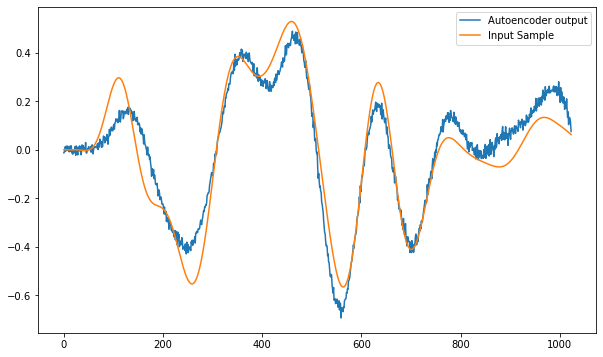

Train Epoch: 6 [0/7673 (0%)]	Loss: 13.076774
Train Epoch: 6 [640/7673 (8%)]	Loss: 12.014533
Train Epoch: 6 [1280/7673 (17%)]	Loss: 10.350744
Train Epoch: 6 [1920/7673 (25%)]	Loss: 10.127887
Train Epoch: 6 [2560/7673 (33%)]	Loss: 11.245346
Train Epoch: 6 [3200/7673 (42%)]	Loss: 10.889059
Train Epoch: 6 [3840/7673 (50%)]	Loss: 13.140738
Train Epoch: 6 [4480/7673 (58%)]	Loss: 9.106044
Train Epoch: 6 [5120/7673 (67%)]	Loss: 9.548429
Train Epoch: 6 [5760/7673 (75%)]	Loss: 11.875870
Train Epoch: 6 [6400/7673 (83%)]	Loss: 11.207446
Train Epoch: 6 [7040/7673 (92%)]	Loss: 7.989600
====> Epoch: 6 Average loss: 10.7973
====> Test set loss: 10.3113
Train Epoch: 7 [0/7673 (0%)]	Loss: 10.818413
Train Epoch: 7 [640/7673 (8%)]	Loss: 8.075056
Train Epoch: 7 [1280/7673 (17%)]	Loss: 9.583537
Train Epoch: 7 [1920/7673 (25%)]	Loss: 8.825182
Train Epoch: 7 [2560/7673 (33%)]	Loss: 8.965760
Train Epoch: 7 [3200/7673 (42%)]	Loss: 10.236029
Train Epoch: 7 [3840/7673 (50%)]	Loss: 10.750908
Train Epoch: 7 [4480/7

<Figure size 432x288 with 0 Axes>

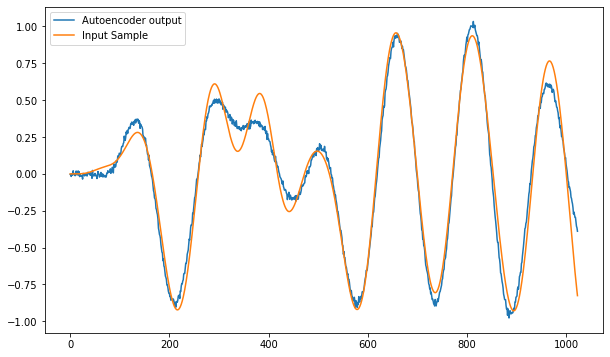

Train Epoch: 11 [0/7673 (0%)]	Loss: 7.106549
Train Epoch: 11 [640/7673 (8%)]	Loss: 5.330010
Train Epoch: 11 [1280/7673 (17%)]	Loss: 6.395049
Train Epoch: 11 [1920/7673 (25%)]	Loss: 5.818942
Train Epoch: 11 [2560/7673 (33%)]	Loss: 6.569588
Train Epoch: 11 [3200/7673 (42%)]	Loss: 5.505569
Train Epoch: 11 [3840/7673 (50%)]	Loss: 5.054350
Train Epoch: 11 [4480/7673 (58%)]	Loss: 6.366656
Train Epoch: 11 [5120/7673 (67%)]	Loss: 4.465686
Train Epoch: 11 [5760/7673 (75%)]	Loss: 5.205397
Train Epoch: 11 [6400/7673 (83%)]	Loss: 6.156440
Train Epoch: 11 [7040/7673 (92%)]	Loss: 5.348403
====> Epoch: 11 Average loss: 6.0505
====> Test set loss: 5.2917
Train Epoch: 12 [0/7673 (0%)]	Loss: 4.549731
Train Epoch: 12 [640/7673 (8%)]	Loss: 5.835359
Train Epoch: 12 [1280/7673 (17%)]	Loss: 5.206325
Train Epoch: 12 [1920/7673 (25%)]	Loss: 5.556870
Train Epoch: 12 [2560/7673 (33%)]	Loss: 4.806528
Train Epoch: 12 [3200/7673 (42%)]	Loss: 4.687670
Train Epoch: 12 [3840/7673 (50%)]	Loss: 4.909871
Train Epoch: 12 

<Figure size 432x288 with 0 Axes>

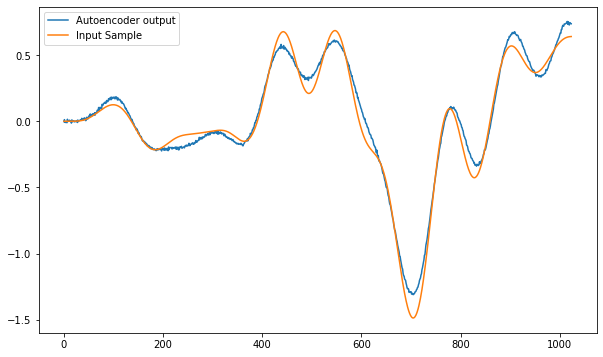

Train Epoch: 16 [0/7673 (0%)]	Loss: 3.907635
Train Epoch: 16 [640/7673 (8%)]	Loss: 2.899269
Train Epoch: 16 [1280/7673 (17%)]	Loss: 3.906759
Train Epoch: 16 [1920/7673 (25%)]	Loss: 3.461374
Train Epoch: 16 [2560/7673 (33%)]	Loss: 3.542332
Train Epoch: 16 [3200/7673 (42%)]	Loss: 3.792669
Train Epoch: 16 [3840/7673 (50%)]	Loss: 2.922769
Train Epoch: 16 [4480/7673 (58%)]	Loss: 3.493973
Train Epoch: 16 [5120/7673 (67%)]	Loss: 3.727602
Train Epoch: 16 [5760/7673 (75%)]	Loss: 3.090996
Train Epoch: 16 [6400/7673 (83%)]	Loss: 3.727538
Train Epoch: 16 [7040/7673 (92%)]	Loss: 3.413827
====> Epoch: 16 Average loss: 3.5135
====> Test set loss: 3.3927
Train Epoch: 17 [0/7673 (0%)]	Loss: 2.424804
Train Epoch: 17 [640/7673 (8%)]	Loss: 3.988569
Train Epoch: 17 [1280/7673 (17%)]	Loss: 3.797629
Train Epoch: 17 [1920/7673 (25%)]	Loss: 3.146298
Train Epoch: 17 [2560/7673 (33%)]	Loss: 3.398488
Train Epoch: 17 [3200/7673 (42%)]	Loss: 3.057351
Train Epoch: 17 [3840/7673 (50%)]	Loss: 3.672228
Train Epoch: 17 

<Figure size 432x288 with 0 Axes>

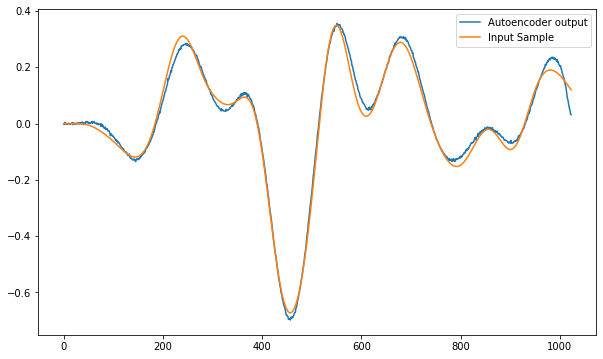

Train Epoch: 21 [0/7673 (0%)]	Loss: 2.379905
Train Epoch: 21 [640/7673 (8%)]	Loss: 2.653461
Train Epoch: 21 [1280/7673 (17%)]	Loss: 3.185922
Train Epoch: 21 [1920/7673 (25%)]	Loss: 2.523913
Train Epoch: 21 [2560/7673 (33%)]	Loss: 2.531355
Train Epoch: 21 [3200/7673 (42%)]	Loss: 2.661835
Train Epoch: 21 [3840/7673 (50%)]	Loss: 3.289977
Train Epoch: 21 [4480/7673 (58%)]	Loss: 2.209504
Train Epoch: 21 [5120/7673 (67%)]	Loss: 2.912620
Train Epoch: 21 [5760/7673 (75%)]	Loss: 2.762185
Train Epoch: 21 [6400/7673 (83%)]	Loss: 2.075065
Train Epoch: 21 [7040/7673 (92%)]	Loss: 2.147538
====> Epoch: 21 Average loss: 2.5412
====> Test set loss: 2.4729
Train Epoch: 22 [0/7673 (0%)]	Loss: 2.152469
Train Epoch: 22 [640/7673 (8%)]	Loss: 2.958863
Train Epoch: 22 [1280/7673 (17%)]	Loss: 2.764312
Train Epoch: 22 [1920/7673 (25%)]	Loss: 2.288537
Train Epoch: 22 [2560/7673 (33%)]	Loss: 2.275848
Train Epoch: 22 [3200/7673 (42%)]	Loss: 2.864835
Train Epoch: 22 [3840/7673 (50%)]	Loss: 2.142366
Train Epoch: 22 

<Figure size 432x288 with 0 Axes>

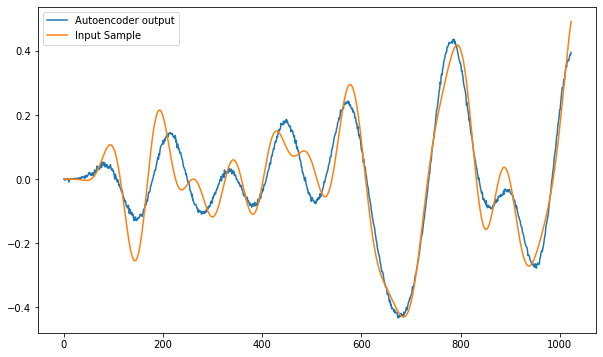

Train Epoch: 26 [0/7673 (0%)]	Loss: 2.027981
Train Epoch: 26 [640/7673 (8%)]	Loss: 1.844271
Train Epoch: 26 [1280/7673 (17%)]	Loss: 2.178720
Train Epoch: 26 [1920/7673 (25%)]	Loss: 2.591173
Train Epoch: 26 [2560/7673 (33%)]	Loss: 2.273110
Train Epoch: 26 [3200/7673 (42%)]	Loss: 2.072738
Train Epoch: 26 [3840/7673 (50%)]	Loss: 1.992670
Train Epoch: 26 [4480/7673 (58%)]	Loss: 2.023593
Train Epoch: 26 [5120/7673 (67%)]	Loss: 2.205188
Train Epoch: 26 [5760/7673 (75%)]	Loss: 1.962797
Train Epoch: 26 [6400/7673 (83%)]	Loss: 2.317514
Train Epoch: 26 [7040/7673 (92%)]	Loss: 2.173228
====> Epoch: 26 Average loss: 2.1536
====> Test set loss: 2.0601
Train Epoch: 27 [0/7673 (0%)]	Loss: 2.242922
Train Epoch: 27 [640/7673 (8%)]	Loss: 2.273187
Train Epoch: 27 [1280/7673 (17%)]	Loss: 1.915517
Train Epoch: 27 [1920/7673 (25%)]	Loss: 2.081470
Train Epoch: 27 [2560/7673 (33%)]	Loss: 2.502494
Train Epoch: 27 [3200/7673 (42%)]	Loss: 1.968148
Train Epoch: 27 [3840/7673 (50%)]	Loss: 2.050348
Train Epoch: 27 

<Figure size 432x288 with 0 Axes>

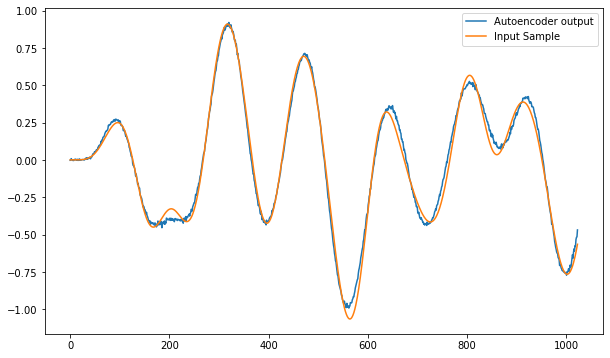

Train Epoch: 31 [0/7673 (0%)]	Loss: 1.504132
Train Epoch: 31 [640/7673 (8%)]	Loss: 1.345383
Train Epoch: 31 [1280/7673 (17%)]	Loss: 1.498506
Train Epoch: 31 [1920/7673 (25%)]	Loss: 1.667031
Train Epoch: 31 [2560/7673 (33%)]	Loss: 1.584569
Train Epoch: 31 [3200/7673 (42%)]	Loss: 1.641920
Train Epoch: 31 [3840/7673 (50%)]	Loss: 1.541055
Train Epoch: 31 [4480/7673 (58%)]	Loss: 1.981868
Train Epoch: 31 [5120/7673 (67%)]	Loss: 1.548645
Train Epoch: 31 [5760/7673 (75%)]	Loss: 1.582675
Train Epoch: 31 [6400/7673 (83%)]	Loss: 1.618604
Train Epoch: 31 [7040/7673 (92%)]	Loss: 1.790986
====> Epoch: 31 Average loss: 1.5782
====> Test set loss: 1.5635
Train Epoch: 32 [0/7673 (0%)]	Loss: 1.791582
Train Epoch: 32 [640/7673 (8%)]	Loss: 1.535812
Train Epoch: 32 [1280/7673 (17%)]	Loss: 1.407892
Train Epoch: 32 [1920/7673 (25%)]	Loss: 1.351789
Train Epoch: 32 [2560/7673 (33%)]	Loss: 1.807104
Train Epoch: 32 [3200/7673 (42%)]	Loss: 1.324048
Train Epoch: 32 [3840/7673 (50%)]	Loss: 1.737554
Train Epoch: 32 

<Figure size 432x288 with 0 Axes>

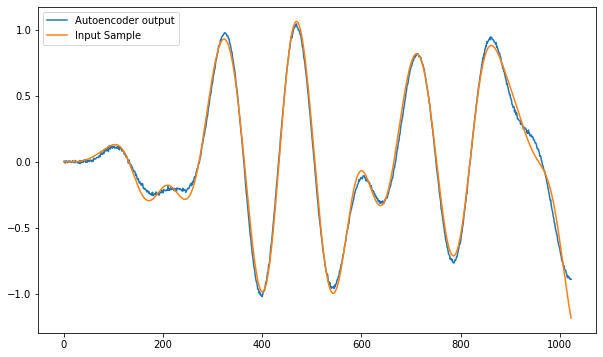

Train Epoch: 36 [0/7673 (0%)]	Loss: 1.628972
Train Epoch: 36 [640/7673 (8%)]	Loss: 1.817405
Train Epoch: 36 [1280/7673 (17%)]	Loss: 1.354953
Train Epoch: 36 [1920/7673 (25%)]	Loss: 1.563567
Train Epoch: 36 [2560/7673 (33%)]	Loss: 1.292417
Train Epoch: 36 [3200/7673 (42%)]	Loss: 1.758398
Train Epoch: 36 [3840/7673 (50%)]	Loss: 1.583583
Train Epoch: 36 [4480/7673 (58%)]	Loss: 1.346464
Train Epoch: 36 [5120/7673 (67%)]	Loss: 1.377535
Train Epoch: 36 [5760/7673 (75%)]	Loss: 1.288693
Train Epoch: 36 [6400/7673 (83%)]	Loss: 1.210516
Train Epoch: 36 [7040/7673 (92%)]	Loss: 1.638955
====> Epoch: 36 Average loss: 1.4953
====> Test set loss: 1.4670
Train Epoch: 37 [0/7673 (0%)]	Loss: 1.553502
Train Epoch: 37 [640/7673 (8%)]	Loss: 1.315992
Train Epoch: 37 [1280/7673 (17%)]	Loss: 1.529446
Train Epoch: 37 [1920/7673 (25%)]	Loss: 1.486719
Train Epoch: 37 [2560/7673 (33%)]	Loss: 1.618149
Train Epoch: 37 [3200/7673 (42%)]	Loss: 1.233939
Train Epoch: 37 [3840/7673 (50%)]	Loss: 1.370340
Train Epoch: 37 

<Figure size 432x288 with 0 Axes>

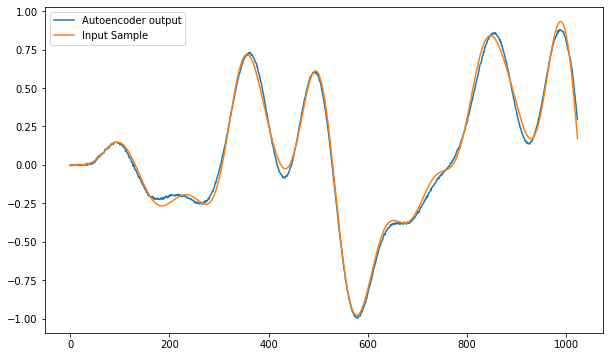

Train Epoch: 41 [0/7673 (0%)]	Loss: 1.616459
Train Epoch: 41 [640/7673 (8%)]	Loss: 1.194402
Train Epoch: 41 [1280/7673 (17%)]	Loss: 1.413165
Train Epoch: 41 [1920/7673 (25%)]	Loss: 1.390704
Train Epoch: 41 [2560/7673 (33%)]	Loss: 1.505625
Train Epoch: 41 [3200/7673 (42%)]	Loss: 1.818967
Train Epoch: 41 [3840/7673 (50%)]	Loss: 1.271287
Train Epoch: 41 [4480/7673 (58%)]	Loss: 1.550164
Train Epoch: 41 [5120/7673 (67%)]	Loss: 1.476696
Train Epoch: 41 [5760/7673 (75%)]	Loss: 1.721866
Train Epoch: 41 [6400/7673 (83%)]	Loss: 1.372429
Train Epoch: 41 [7040/7673 (92%)]	Loss: 1.205359
====> Epoch: 41 Average loss: 1.4486
====> Test set loss: 1.4426
Train Epoch: 42 [0/7673 (0%)]	Loss: 1.311382
Train Epoch: 42 [640/7673 (8%)]	Loss: 1.545650
Train Epoch: 42 [1280/7673 (17%)]	Loss: 1.370124
Train Epoch: 42 [1920/7673 (25%)]	Loss: 1.368672
Train Epoch: 42 [2560/7673 (33%)]	Loss: 1.415635
Train Epoch: 42 [3200/7673 (42%)]	Loss: 1.514489
Train Epoch: 42 [3840/7673 (50%)]	Loss: 1.352732
Train Epoch: 42 

<Figure size 432x288 with 0 Axes>

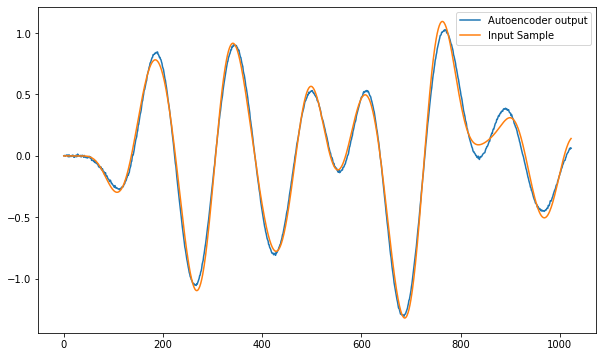

Train Epoch: 46 [0/7673 (0%)]	Loss: 1.263125
Train Epoch: 46 [640/7673 (8%)]	Loss: 1.300064
Train Epoch: 46 [1280/7673 (17%)]	Loss: 1.201976
Train Epoch: 46 [1920/7673 (25%)]	Loss: 1.276269
Train Epoch: 46 [2560/7673 (33%)]	Loss: 1.263227
Train Epoch: 46 [3200/7673 (42%)]	Loss: 1.424592
Train Epoch: 46 [3840/7673 (50%)]	Loss: 1.258347
Train Epoch: 46 [4480/7673 (58%)]	Loss: 1.124997
Train Epoch: 46 [5120/7673 (67%)]	Loss: 1.203304
Train Epoch: 46 [5760/7673 (75%)]	Loss: 1.243471
Train Epoch: 46 [6400/7673 (83%)]	Loss: 1.084352
Train Epoch: 46 [7040/7673 (92%)]	Loss: 1.318479
====> Epoch: 46 Average loss: 1.3143
====> Test set loss: 1.3370
Train Epoch: 47 [0/7673 (0%)]	Loss: 1.433297
Train Epoch: 47 [640/7673 (8%)]	Loss: 1.351544
Train Epoch: 47 [1280/7673 (17%)]	Loss: 1.352211
Train Epoch: 47 [1920/7673 (25%)]	Loss: 1.392428
Train Epoch: 47 [2560/7673 (33%)]	Loss: 1.468999
Train Epoch: 47 [3200/7673 (42%)]	Loss: 1.443940
Train Epoch: 47 [3840/7673 (50%)]	Loss: 1.103152
Train Epoch: 47 

<Figure size 432x288 with 0 Axes>

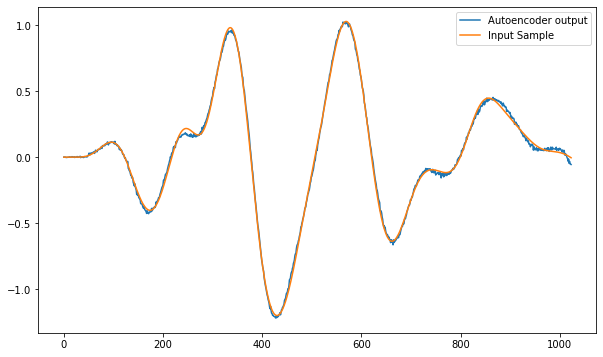

In [12]:
# Train the Autoencoder on our EEG data!
for epoch in range(1, EPOCHS+1):
    train(epoch)
    test(epoch)
    if epoch % EPOCHS_INTERVAL == 0:
        with torch.no_grad():
            plt.figure()
            plt.figure(figsize=(10,6))
            sample = full_dataset[random.randint(0,len(full_dataset))]
            x= model.encode(torch.from_numpy(sample).cuda()) 
            out = model.decode(x)
            out = out.cpu().detach().numpy()

            plt.plot(out, label='Autoencoder output') 
            plt.plot(sample, label='Input Sample')
            plt.legend()
            plt.show()

In [13]:
# Save the trained
torch.save(model.state_dict(), 'Autoencoder_EEG.pt')

In [14]:
# Load a trained model
model = AE(AE_PARAMS)
model.load_state_dict(torch.load('Autoencoder_EEG.pt'))
model.eval()

# Push it onto the GPU
model.cuda()

AE(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=1024, bias=True)
)

<Figure size 432x288 with 0 Axes>

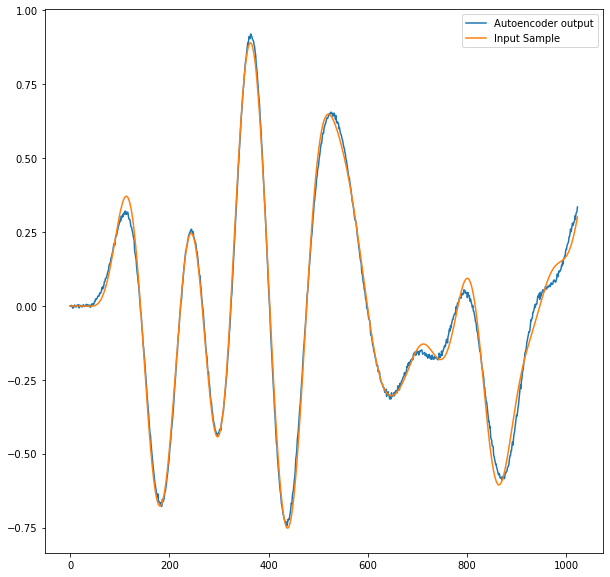

In [16]:
# Test the loaded model
with torch.no_grad():
    plt.figure()
    plt.figure(figsize=(10,10))
    sample = full_dataset[random.randint(0,len(full_dataset))]
    x= model.encode(torch.from_numpy(sample).cuda()) 
    out = model.decode(x)
    out = out.cpu().detach().numpy()

    plt.plot(out, label='Autoencoder output') 
    plt.plot(sample, label='Input Sample')
    plt.legend()
    plt.show()